# 0. Setup Paths

In [2]:
import os

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [23]:
!pip install tensorflow tensorflow-gpu --upgrade

Requirement already up-to-date: tensorflow in d:\nouveau dossier\lib\site-packages (2.7.0)
Requirement already up-to-date: tensorflow-gpu in d:\nouveau dossier\lib\site-packages (2.7.0)


In [ ]:
!pip install pyyaml

In [ ]:
!pip install Pillow

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [24]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [6]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!pip install pytz

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
import tensorboard

In [7]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [8]:
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [10]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [7]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [19]:
import tensorboard
tensorboard --logdir

NameError: name 'logdir' is not defined

In [ ]:
!{command}

# 7. Evaluate the Model

In [8]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [9]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [36]:
!pip install tensorflow-addons

  Using cached tensorflow_addons-0.15.0-cp38-cp38-win_amd64.whl (753 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tf-models-official 2.7.0 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.7.0 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.7.0 requires oauth2client, which is not installed.
tf-models-official 2.7.0 requires opencv-python-headless, which is not installed.
tf-models-official 2.7.0 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.7.0 requires seqeval, which is not installed.
tf-models-official 2.7.0 requires tensorflow-datasets, which is not installed.
tf-models-official 2.7.0 requires tensorflow-hub>=0.6.0, which is not installed.
tf-models-official 2.7.0 requires tensorflow-model-optimization>=0.4.1, which is no

In [37]:
!{command}

2022-01-22 15:16:41.125298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-01-22 15:16:41.125340: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-22 15:16:51.686359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-01-22 15:16:51.688330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-01-22 15:16:51.690297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-01-22 15:16:51.692258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

creating index...
index created!
creating index...
index created!

Use `tf.data.Dataset.map()
W0122 15:16:54.124581 39224 deprecation.py:341] From D:\Nouveau dossier\lib\site-packages\object_detection-0.1-py3.8.egg\object_detection\builders\dataset_builder.py:236: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.



Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.573


Instructions for updating:
Use `tf.data.Dataset.map()
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0122 15:16:59.180736 39224 deprecation.py:341] From D:\Nouveau dossier\lib\site-packages\tensorflow\python\util\dispatch.py:1096: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W0122 15:17:01.059080 39224 deprecation.py:341] From D:\Nouveau dossier\lib\site-packages\tensorflow\python\autograph\impl\api.py:465: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Waiting for new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet
I0122 15:17:06.084758 39224 checkpoint_utils.py:140] Waiting for new checkpoint a

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600



Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Finished eval step 0
I0122 15:17:33.002784 39224 model_lib_v2.py:966] Finished eval step 0
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0122 15:17:33.276618 39224 deprecation.py:341] From D:\Nouveau dossier\lib\site-packages\tensorflow\python\autograph\impl\api.py:465: py_func (from tensorflow.python.op

# 8. Load Train Model From Checkpoint

In [15]:
!pip install tensorflow

In [7]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [7]:
tf.test.gpu_device_name()
gpus = tf.config.list_physical_devices('GPU')

In [8]:
gpus

[]

In [9]:

if gpus :
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [9]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [11]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test' ,'Cars411.png')

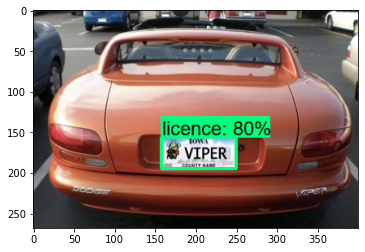

In [12]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

In [43]:
detections['detection_boxes'].size

400

# Apply OCE to detection

In [ ]:
!pip install easyocr

In [ ]:
!pip3 install torch==1.10.0+cu102 torchvision==0.11.1+cu102 torchaudio===0.10.0+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html


In [13]:
import easyocr

D:\Nouveau dossier\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [14]:
detection_treshold = 0.6

In [34]:
image = image_np_with_detections
scores = list(filter(lambda x: x>detection_treshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [35]:
boxes

array([[0.5824057, 0.3927861, 0.72711  , 0.6273846]], dtype=float32)

In [36]:
width=image.shape[1]
height=image.shape[0]

In [37]:
height

268

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.5824057 0.3927861 0.72711   0.6273846]
[156.08472395 157.11443424 194.86548758 250.95384121]
[([[24, 8], [86, 8], [86, 32], [24, 32]], 'VIPER', 0.9994524679103454)]


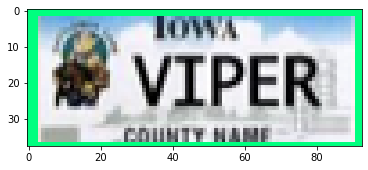

In [38]:
#Applying ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi=box*[height,width,height,width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result=reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))
    

In [39]:
ocr_result[0][1]

'VIPER'

In [71]:
ocr_result[0][-1]

IndexError: list index out of range

In [90]:
ocr_accuracy = [x for x in ocr_accuracy if str(x) != 'nan']
ocr_accuracy

[0.9994524679103454,
 0.9621784320263116,
 0.2328553973793033,
 0.7142259093209968,
 0.5160325559427967,
 0.8574851564388716,
 0.5718920840737034,
 0.48277222819733634,
 0.27221359598745104,
 0.31281226570172593,
 0.751787964663979,
 0.6273666458166001,
 0.24660931495200628,
 0.1707017552073396,
 0.7507637025115015,
 0.43115754252659244,
 0.5586445053824423,
 0.6430233377716167]

In [91]:
np.mean(ocr_accuracy)

0.5612208256561622

In [84]:
ocr_taux_confiance

[0.9994524679103454,
 0.9621784320263116,
 0.2328553973793033,
 0.7142259093209968,
 0.5087833419032972,
 0.5232817699822964,
 0.8574851564388716,
 0.9753967849248268,
 0.16838738322257996,
 0.28965747356414795,
 0.15930556379580552,
 0.9993536472320557,
 0.27221359598745104,
 0.04822917311808584,
 0.577395358285366,
 0.751787964663979,
 0.6273666458166001,
 0.24660931495200628,
 0.1707017552073396,
 0.7507637025115015,
 0.4735955557540694,
 0.38871952929911546,
 0.9982077966945643,
 0.11908121407032013,
 0.6430233377716167]

In [87]:

np.mean(ocr_accuracy)

nan

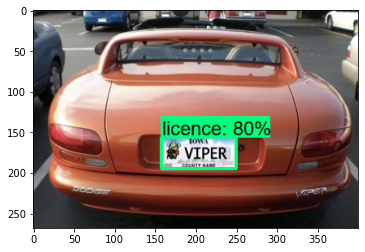

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.5824057 0.3927861 0.72711   0.6273846]
[156.08472395 157.11443424 194.86548758 250.95384121]
VIPER
0.9994524679103454


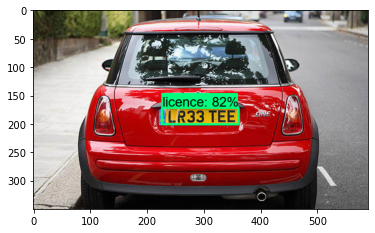

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.4916906  0.384404   0.57285744 0.61390406]
[172.09171206 226.79836214 200.50010383 362.20339477]
R33 TEE
0.9621784320263116


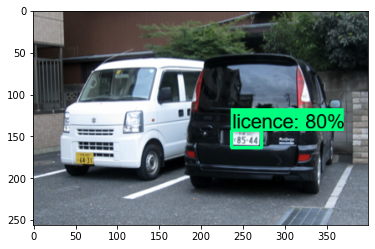

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.55893886 0.5917481  0.6371242  0.6828402 ]
[143.08834839 236.69924736 163.10379028 273.13609123]


D:\Nouveau dossier\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


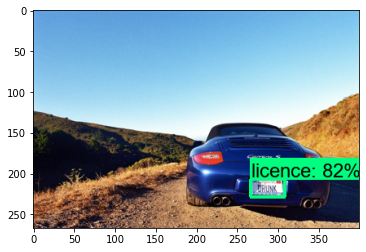

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.77688295 0.66700214 0.8574737  0.7725076 ]
[207.42774671 266.80085659 228.94547027 309.00304317]
DRUNK
0.2328553973793033


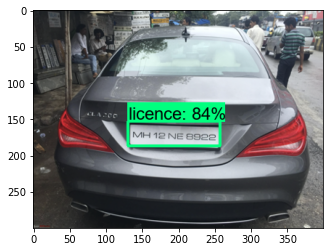

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.5124291  0.32715553 0.6217731  0.64578444]
[153.72873545 130.86221218 186.53193712 258.31377506]
MH1ZNE B922
0.7142259093209968


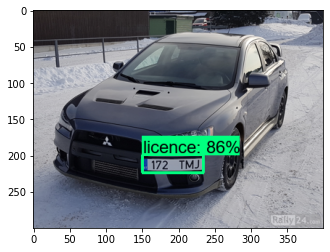

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.6653473  0.37661207 0.74450415 0.58925474]
[199.60418344 150.64482689 223.35124612 235.70189476]
172
0.5087833419032972
IMJ
0.5232817699822964


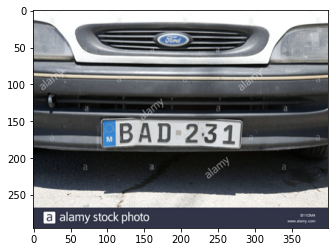

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.49460092 0.22546725 0.6315522  0.7114666 ]
[145.90727195  90.1868999  186.30790472 284.58664417]
BAD 231
0.8574851564388716


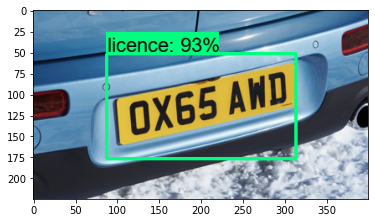

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.23435393 0.2199569  0.7823982  0.7872541 ]
[ 52.7296342   87.98276186 176.03960037 314.90163803]
AND
0.9753967849248268
OX6s
0.16838738322257996


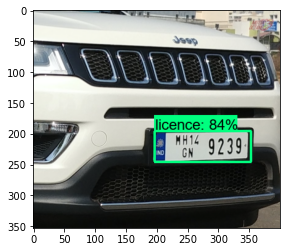

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.5556071  0.4919491  0.6940564  0.88379145]
[196.1292994  196.77964449 245.00190628 353.51657867]
MHIL
0.28965747356414795
Cn
0.15930556379580552
9239
0.9993536472320557


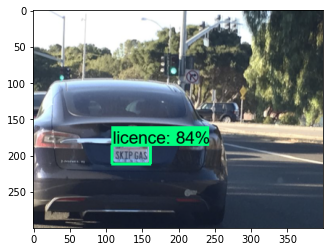

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.6229116  0.27176964 0.7046913  0.40649503]
[186.87347174 108.70785713 211.40738726 162.59801388]
Skip Gas
0.27221359598745104


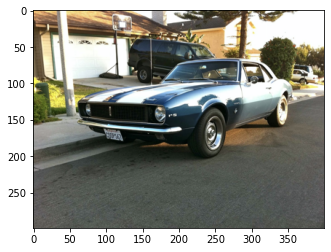

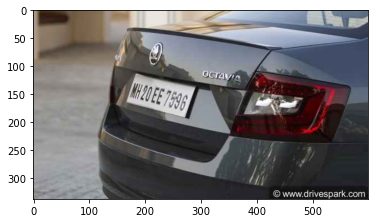

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.34531146 0.27885258 0.5972668  0.4671734 ]
[116.71527445 167.31154919 201.87617612 280.30403852]
MHZOEE =
0.04822917311808584
7696
0.577395358285366


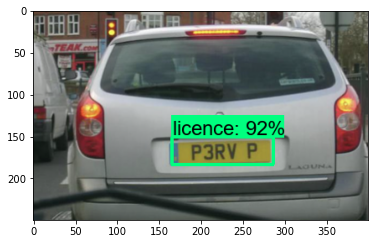

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.60592085 0.4143229  0.7329679  0.7185555 ]
[151.48021281 165.72916508 183.24197829 287.42220402]
P3RV_P
0.751787964663979


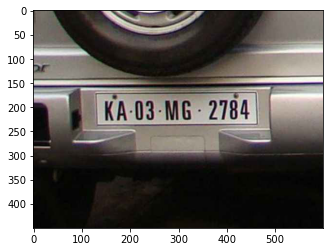

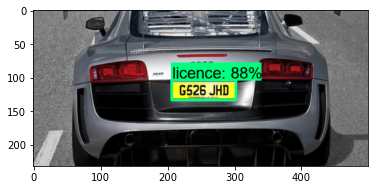

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.44912955 0.4129399  0.57679176 0.6067685 ]
[104.19805598 206.46995306 133.81568909 303.38424444]
6526 JHD
0.6273666458166001


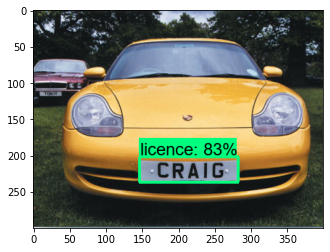

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.6742719  0.36552924 0.78969675 0.7093583 ]
[202.28156447 146.21169567 236.90902591 283.74330997]
cRAiG
0.24660931495200628


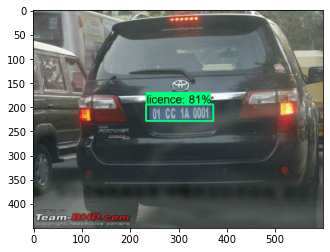

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.43336695 0.38928938 0.5076348  0.62228036]
[195.01512945 233.57362747 228.43566835 373.36821556]
01 CC IA O001
0.1707017552073396


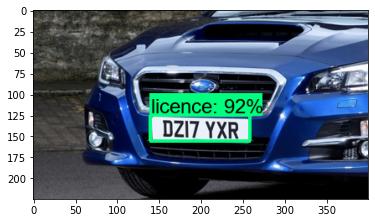

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.55870694 0.3490767  0.69194585 0.64893544]
[125.70906132 139.63067532 155.68781644 259.57417488]
DZI7 YXR
0.7507637025115015


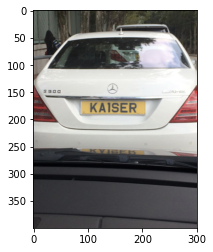

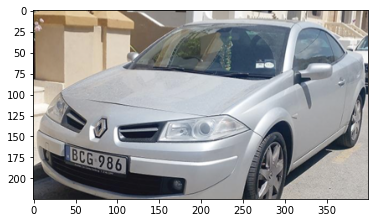

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.69245386 0.09194765 0.8887385  0.27408776]
[155.80211878  36.77906096 199.96616542 109.63510275]
986
0.4735955557540694
BCG
0.38871952929911546


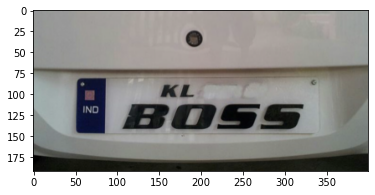

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.43210056 0.20457482 0.74403465 0.83570087]
[ 82.96330833  81.82992935 142.8546524  334.28034782]
KL
0.9982077966945643
80ss
0.11908121407032013


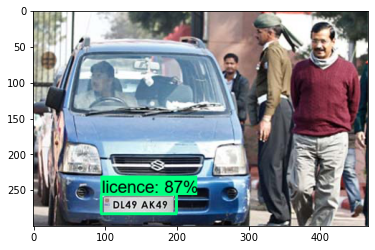

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.8539726  0.20142019 0.9412202  0.43003744]
[256.19178414  94.06322777 282.36606717 200.82748395]
DL49 AK49
0.6430233377716167


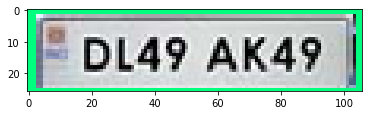

In [86]:
#Test de Confiance de l'OCR sur les images de test
for i in range(22):
    IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test' ,'Cars4'+str(i+11)+'.png')
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

    image = image_np_with_detections
    scores = list(filter(lambda x: x>detection_treshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]

    width=image.shape[1]
    height=image.shape[0]

    #Applying ROI filtering and OCR
    for idx, box in enumerate(boxes):
        print(box)
        roi=box*[height,width,height,width]
        print(roi)
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
        ocr_taux_confiance=[]
        for i in range(len(ocr_result)):
            try:
                ocr_taux_confiance.append(ocr_result[i][2])
                print(ocr_result[i][1])
                print(ocr_result[i][2])
            except:
                print("Pas trouvé de texte")
        
        ocr_accuracy.append(np.mean(ocr_taux_confiance))
        plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))

# OCR Filtering

In [15]:
region_threshold = 0.05 # plus gros -> on garde le texte avec la police la plus grosse
detection_threshold = 0.7 #on prend que ce dont on est sûrs à plus de x%

In [16]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    plate=[]
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
        #print(result[1])
    return plate

In [42]:
filter_text(region,ocr_result,region_threshold)

['VIPER']

# Bring it together

In [17]:

#OCR de base
def ocr_it(image, detections, detection_threshold, region_threshold):
    scores = list(filter(lambda x: x>detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    width=image.shape[1]
    height=image.shape[0]
    
    #Applying ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi=box*[height,width,height,width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
        
        text = filter_text(region,ocr_result,region_threshold)
        #region=cv2.detailEnhance(region,kernel=10,range=0.15)
        plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text,region

In [16]:
from skimage.filters import threshold_otsu
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters
from skimage.morphology import opening, closing, disk
from skimage.segmentation import mark_boundaries

In [17]:

#OCR avec traitement d'image
def ocr_it(image, detections, detection_threshold, region_threshold):
    scores = list(filter(lambda x: x>detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    width=image.shape[1]
    height=image.shape[0]
    
    #Applying ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi=box*[height,width,height,width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
        
        
        
        
        
        img = cv2.cvtColor(region, cv2.COLOR_BGR2RGB)
        #conversion de l'image en une matrice de pixels avec 3 couleurs RGB, donc matrice MxNx3. Chaque ligne est un vecteur dans l'espace 3D des RGB
        pixel_values = img.reshape((-1, 3))
        # conversion en décimal (nécessaire pour la méthode d'OpenCV)
        pixel_values = np.float32(pixel_values)
        print(pixel_values)
        print(pixel_values.shape)

        # définition du critère d'arrêt.
        #EPS arrête l'algo si epsilon est atteint (la précision)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

        # nombre de clusters (K) on peut aussi mettre 2 pour n'avoir que 2 couleurs
        k = 3
        _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # reconversion en valeurs 8 bit
        centers = np.uint8(centers)

        # flatten la matrice de labels
        labels = labels.flatten()

        # conversion de tous les pixels en la couleur des centroids
        segmented_image = centers[labels.flatten()]
        seg=segmented_image
       
        # redimension dans la taille d'origine
        segmented_image = segmented_image.reshape(img.shape)


        segmented_image = cv2.GaussianBlur(segmented_image,(5,5),0)
        
        """
        mask=segmented_image
        mask=closing(opening(mask,disk(1)),disk(2)) #opening remove small objects, closing removes the holes in the objects
        plt.figure()
        plt.imshow(mark_boundaries(image_np_with_detections,mask))
        plt.show()"""
        
        """
        # affichage
        plt.imshow(segmented_image)
        plt.title('Segmentation K mean avec '+str(k)+' clusters')
        plt.show()
        """
        
        
        
        
        text = filter_text(segmented_image,ocr_result,region_threshold)
        
        plt.imshow(cv2.cvtColor(segmented_image,cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text,segmented_image

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


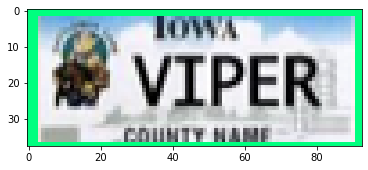

['VIPER']


In [44]:
text,region = ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)

# 10. Real Time Detections from your Webcam

In [ ]:
#!pip uninstall opencv-python-headless -y

In [ ]:
#pip install opencv-python
#!pip install opencv-contrib-python
!pip install opencv-python==2.4.0

In [22]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, axis=0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(int)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    


    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


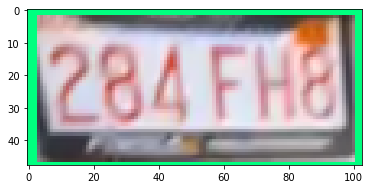

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['1234FHd']


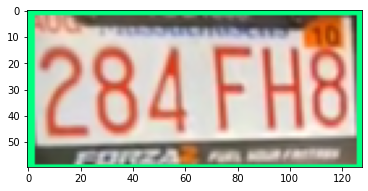

['284FHd']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


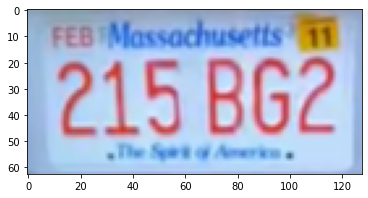

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['215 BGz']


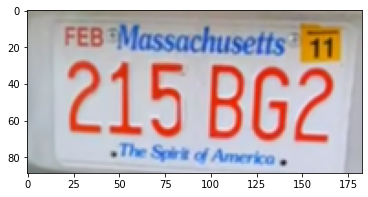

['Massachusetts', '215 BGZ']


In [21]:
cap = cv2.VideoCapture(0) #0 si on utilise la caméra principale
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, axis=0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(int)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        #save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')